# 1. Sgr A* Flares Spectrum
__Some housekeeping__
* Run this notebook in Python 3.

The Sgr A* spectrum is given in figure 1. (Yuan et al. 2003)

![title](img/SpectrumYuan2003.PNG)


__Goals of this notebook__

* Create a seed distribution synchroton photons from a mildly relativistic electrons.
* Perform (at least one) IC scatterings.
* Put all of the machinery into the correct geometry, with the goal of reproducing the spectrum of flares in Sgr A* jets.


First we do some necessary python imports.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.integrate as integrate
from scipy.integrate import quad
from scipy.special import kv, gamma

Some constants

In [2]:
m_e=9.1*10**-28   #electron mass [g]
e=5*10**-10;      #electron charge [esu]
k=1.4*10**-16;    #boltzmann constnat [erg/K]
c=3*10**10;       #speed of light [cm/s]
B=3               #magnetic field [Gauss]
theta=np.pi/2     #synchroton angle between velocity and field [rad]
h=10**-27         #reduced planck constant [erg s]
log_omega_min=5
log_omega_max=11

gamma_min=1
gamma_max=20


# Maxwell-Jüttner distribution of electrons
The velocity distribution of electrons that will produce the synchroton radiation is that of mildly relativistic electrons: $kT \sim m_e c^2$. 
$$
        N(\gamma)=N_0\frac{\gamma^2\beta}{\theta K_2(1/\theta)}\text{exp}(-\frac{\gamma}{\theta}),
$$
where $\theta = \frac{kT}{m_e c^2}$, and $K_2$ is the modified Bessel function of the second kind. 

Q: WHAT TO DO WITH $N_0$ (related to normalization)

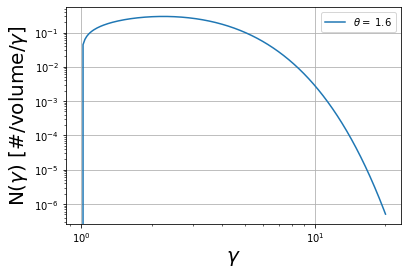

In [3]:
def MJ_of_gamma(gamma):
    beta=np.sqrt(1-1/gamma**2)
    theta=1 # electron thermal energy in fractions of electron mass.
    f=gamma**2*beta*np.exp(-gamma/theta)/(theta*kv(2,1./theta))
    return(f)
    
    
gamma = np.linspace(1,20,1000)
MJ = np.zeros(len(gamma))

for i in range(len(gamma)):
    MJ[i] = MJ_of_gamma(gamma[i])


plt.plot(gamma,MJ,label=r'$\theta=${:4.1f}'.format(theta))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\gamma$',fontsize=20)
plt.ylabel('N($\gamma$) [#/volume/$\gamma$]', fontsize=20)
plt.grid(1)
plt.legend()
plt.show()

# Synchrotron power spectrum
The synchrotron power spectrum for a single electron is given by
$$
    P_{sync}(\omega)=\frac{\sqrt{3} e^3 B \sin{\theta}}{2\pi m_e c^2} F(x),
$$
where
$$
   F(x) = x \int_x^\infty K_{5/3}(\xi)d\xi,
$$
        and $x=\omega/\omega_c$. Also, $\omega_c=\frac{3}{2}\gamma^2\frac{eB}{m_e c}\sin{\theta}$. This implies that $\omega_c=\omega_c(\gamma)$ and thus that $F(x)=F(\gamma,\omega)$ and $P_{sync}(\omega)=P_{sync}(\gamma,\omega,\theta,B)$.
        
Next up, we make some functions that we will need to obtain the synchroton power spectrum as a function of magnetic field, lorentz factor and pitch angle.

In [4]:
def omega_c(gamma,B,theta):
    value=3/2*gamma**2*e*B/(m_e*c)*np.sin(theta)
    return(value)

def K_fivethird(x):
    value=kv(5/3,x)
    return(value)

def F_sync(omega,omega_c):
    x=omega/omega_c
    output_integral,error=quad(K_fivethird,x,np.inf)
    value=x*output_integral
    return(value)

def P_sync(gamma,omega,B,theta):
    value = np.sqrt(3)*e**3*B*np.sin(theta)/(2*np.pi*m_e*c**2)*F_sync(omega,omega_c(gamma,B,theta))
    return(value)




And we test the function out.

according to peak frequency formula, the peak should be at 2.473e+09 or 10^9.39


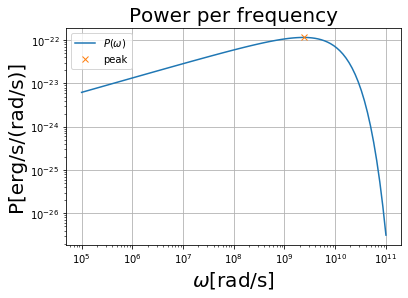

In [5]:
number = 100


omega = np.logspace(log_omega_min,log_omega_max,number)
P = np.zeros(number)

gamma = 10


for i in range(number):
    P[i] = P_sync(gamma,omega[i],B,theta)

omega_peak=0.3*omega_c(gamma,B,theta)
print('according to peak frequency formula, the peak should be at {0:5.3e} or 10^{1:3.2f}'.format(omega_peak,np.log10(omega_peak)))

plt.plot(omega,P, label='$P(\omega)$')
plt.plot(omega_peak,P_sync(gamma,omega_peak,B,theta),'x', label='peak')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title(r'Power per frequency',fontsize=20)
plt.xlabel(r'$\omega$[rad/s]',fontsize=20)
plt.ylabel(r'P[erg/s/(rad/s)]',fontsize=20)
plt.grid(1)
plt.show()


plt.show()

Now we want to combine the velocity distribution and power spectrum into a total spectrum, by 

$$
    P_{tot}(\omega)= \int P_{sync}(\gamma, \omega) N(\gamma) d\gamma
$$

In [6]:
def P_tot(gamma_min,gamma_max,omega,B,theta):
    def P_of_gamma(gamma):
        value=P_sync(gamma,omega,B,theta)
        return(value)
    def integrand(gamma):
        value=MJ_of_gamma(gamma)*P_of_gamma(gamma)
        return(value)
    output,error=quad(integrand,gamma_min,gamma_max)
    value=output
    return(output)
            

Try it out

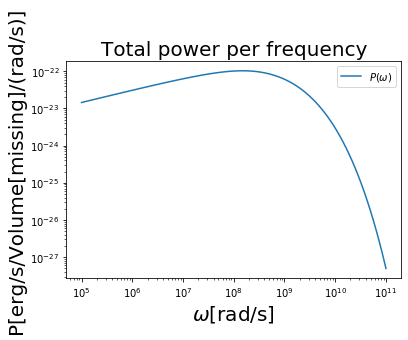

In [7]:
number=100
omega=np.logspace(log_omega_min,log_omega_max,number)


P=np.zeros(number)

for i in range(number):
    P[i]=P_tot(gamma_min,gamma_max,omega[i],B,theta)

plt.plot(omega,P, label='$P(\omega)$')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title(r'Total power per frequency',fontsize=20)
plt.xlabel(r'$\omega$[rad/s]',fontsize=20)
plt.ylabel(r'P[erg/s/Volume[missing]/(rad/s)]',fontsize=20)
plt.show()



# The seed photon distribution
We now want to be able to use this result to create some seed photons, according to the above distribution. To do this, we have to create a function that will return a random photon according to the above distribution. I will first make a PDF, and use it to make a cumulative PDF. 

In [8]:
def N_of_omega(omega):
        value=P_tot(gamma_min,gamma_max,omega,B,theta)/(h*omega) #NUMBER OF PHOTONS
        return(value)

norm,error=quad(N_of_omega,10**log_omega_min,10**log_omega_max) #normalization value, calculate this once, here. 
print('normalization factor is {0:5.3e}'.format(norm))

def N_photon_PDF(omega):
    return(N_of_omega(omega)/norm)

normalization factor is 6.173e+05


Now test if it works.

surface under graph 1.000e+00


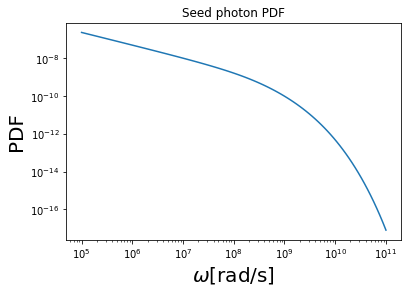

In [9]:
number=100
omega=np.logspace(log_omega_min,log_omega_max,number)
P=np.zeros(number)

surface,error=quad(N_photon_PDF,10**log_omega_min,10**log_omega_max)
print('surface under graph {0:5.3e}'.format(surface))


for i in range(number):
    P[i]=N_photon_PDF(omega[i])
   
plt.plot(omega,P)
plt.title('Seed photon PDF')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\omega$[rad/s]',fontsize=20)
plt.ylabel(r'PDF',fontsize=20)
plt.show()

Then we take this PDF and turn it into a CDF.

In [10]:
def N_photon_CDF(omega):
    integ=np.zeros(number)
    integ[0]=N_photon_PDF(omega[0])
    for i in range(number-1):
        integ[i+1],error=quad(N_photon_PDF,omega[i],omega[i+1]) #integrate the PDF between every omega interval
    
    CDF=np.zeros(number)
    CDF[0]=integ[0]
    for i in range(number-1):
        CDF[i+1]=sum(integ[0:i+2]) # add up the intervals to create a CDF
    return(CDF)

Make a quick plot:

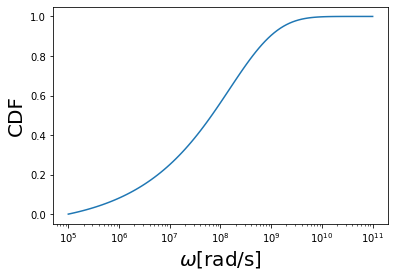

In [11]:
number = 100
omega=np.logspace(log_omega_min,log_omega_max,number)
CDF = N_photon_CDF(omega) 


plt.plot(omega,CDF)
plt.xscale('log')
plt.xlabel(r'$\omega$[rad/s]',fontsize=20)
plt.ylabel(r'CDF',fontsize=20)
plt.show()

Next up we want to invert the CDF and create a function  𝜔(𝑃) , where  𝑃  is a random variable. Many photons drawn using  𝜔(𝑃)  are then distributed with an  𝜔  according to the PDF.

In [12]:
def N_omega_of_P(omega, CDF,n_photons):
    e_phot=np.interp(np.random.rand(n_photons),CDF,omega)
    return(e_phot)

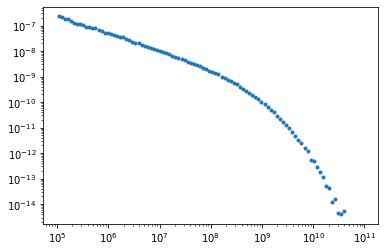

In [36]:
n_photons=100000
photons=np.zeros(n_photons)
number=100
omega=np.logspace(log_omega_min,log_omega_max,number)
omega_phot=N_omega_of_P(omega,CDF,n_photons)

plot_bins_lin=np.linspace(10**log_omega_min,10**log_omega_max,1000)
photon_dist,edges=np.histogram(omega_phot,bins=plot_bins,density=True)
plot_omegas=np.sqrt(plot_bins[1:]*plot_bins[:-1])
plt.loglog(plot_omegas,photon_dist,'.')
plt.show()